# Very simple CGAN
This is a simple example based on François Chollet in his book "Deep Learning with Python". We will generate images of cars of 32x32 pixels.

## What is a GAN
A generative Adversarial Networks is a (at least two) series of ML models that competes one against the other.

![GAN learn flow](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/09/07/practical_gan_2.gif)

The flow is the following:
1. Create generator model. This model is that will generate the fakes images. It's input is only noise. A simple vector of random values between 0 and 1.+
2. Create the discriminator. This model will clasify images between fakes and real. It's input is the images. It will learn to say if an image is real or not and will give to the generator some info about it, allowing the generator to learn to generate best images.
3. We will link these two models and make the discriminator non trainable. By this way, generator will learn to generate best images.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

First of all we generate the train dataset ensuring each image can be loaded.

In [ ]:
from pathlib import Path
from PIL import Image
import glob
import numpy as np
import random

path_base = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
allfiles = [f for f in glob.glob(path_base + "/**/*.jpg", recursive=True)]
random.shuffle(allfiles)

files = []
for i in range(0, len(allfiles)):
    my_file = Path(allfiles[i])
    if my_file.is_file():
        im = Image.open(my_file)
        image = np.array(im)
        if image.ndim == 3:
            files.append(allfiles[i])
        else:
            print(allfiles[i])

path_base = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
allfiles = [f for f in glob.glob(path_base + "/**/*.jpg", recursive=True)]
random.shuffle(allfiles)

for i in range(0, len(allfiles)):
    my_file = Path(allfiles[i])
    if my_file.is_file():
        im = Image.open(my_file)
        image = np.array(im)
        if image.ndim == 3:
            files.append(allfiles[i])
        else:
            print(allfiles[i])

train_df = np.array(files)
train_df.shape

/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/05177.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/07774.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi TTS Coupe 2012/01085.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/02176.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/06947.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi V8 Sedan 1994/04848.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/07693.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/03539.jpg
/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Spyker C8 Coupe 2009/05502.jpg
/kaggle/input

(16151,)

Then import the libraries

In [ ]:
import numpy as np
from scipy import misc
from PIL import Image, ImageOps
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle
from pathlib import Path

In [ ]:
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import densenet
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras import backend as K
from keras import datasets
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

Using TensorFlow backend.


In [ ]:
'''
The latent space itself has no meaning. Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one.
 Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.
'''
latent_dim = 100
height = 32
width = 32
channels = 3
batch_size = 32

Now we create the generator model.

In [ ]:
def build_generator():
    generator_input = layers.Input(shape=(latent_dim,))

    # First, transform the input into a 16x16 128-channels feature map
    x = layers.Dense(128 * 16 * 16)(generator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((16, 16, 128))(x)

    # Then, add a convolution layer
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Few more conv layers
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Produce a 32x32 1-channel feature map
    x = layers.Conv2D(channels, 7, padding='same')(x)
    x = layers.LeakyReLU()(x)
    generator = Model(generator_input, x)
    generator.summary()

    return generator

And then, the discriminator.

In [ ]:
def build_discriminator():
    discriminator_input = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(128, 3)(discriminator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)

    # One dropout layer - important trick!
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(10)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.4)(x)

    # Classification layer
    x = layers.Dense(1)(x)

    discriminator = Model(discriminator_input, x)
    discriminator.summary()

    return discriminator

The next step is link both generator and discriminator and set discriminator non-trainable inside the gan model.

In [ ]:
def build_gan(discriminator, generator):
    # Set discriminator weights to non-trainable
    # (will only apply to the `gan` model)
    discriminator.trainable = False

    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)

    return gan

Now, we have to compile discriminator model and the gan model.

In [ ]:
discriminator = build_discriminator()
discriminator_optimizer = RMSprop(lr=0.001, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='mse')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6, 6, 128)         0   

In [ ]:
generator = build_generator()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

In [ ]:
gan = build_gan(discriminator, generator)
gan_optimizer = RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='mse')

The following code block load the image into a np array

In [ ]:
from pathlib import Path
from PIL import Image, ImageOps

def generate_real(data, index, size):
    im = Image.open(data[index])
    im = ImageOps.fit(im, size, Image.ANTIALIAS)
    npimage = np.array(im)
    npimage = npimage / 255

    return npimage

The following blocks shows generated images

In [ ]:
def plot_images(save2file=False, fake=True, samples=16, images=None, dpi = 80):
    mul = samples

    plt.figure(figsize=(mul*width/dpi,mul*height/dpi))
    for i in range(samples):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [width, height, channels])
        plt.imshow((image * 255).astype(np.uint8))
        plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [ ]:
def plot_image(image, save2file=False, dpi=80):
    plt.figure(figsize=(width/dpi,height/dpi))
    image = np.reshape(image, [width, height, channels])
    plt.imshow((image * 255).astype(np.uint8))
    plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

float64


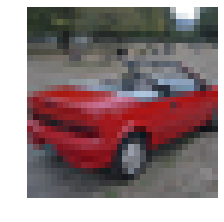

In [ ]:
im = generate_real(train_df, 10, (width, height))
print(im.dtype)
plot_image(im, False, dpi=10)

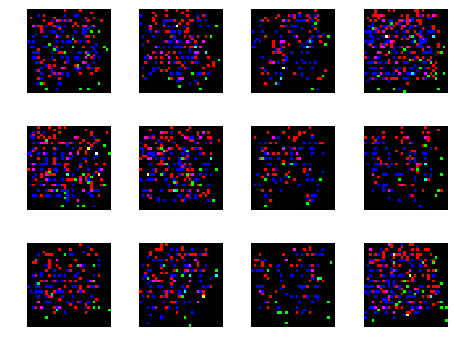

In [ ]:
generated_images = generator.predict(np.random.normal(size=(batch_size, latent_dim)))
plot_images(save2file=False, fake=True, samples=12, images=generated_images, dpi=60)

The following block is the train proccess

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0:	 1.5184099674224854 	-- adversarial loss at step 0:	 0.23319435


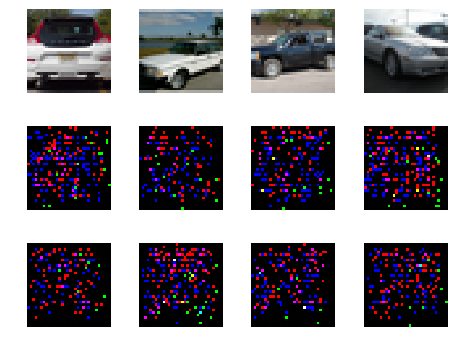

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 100:	 1.0257244110107422 	-- adversarial loss at step 100:	 1.9573971
discriminator loss at step 200:	 0.8360654711723328 	-- adversarial loss at step 200:	 2.7202237
discriminator loss at step 300:	 0.9569880962371826 	-- adversarial loss at step 300:	 2.1743639
discriminator loss at step 400:	 1.0229942798614502 	-- adversarial loss at step 400:	 1.2448133
discriminator loss at step 500:	 0.9991884231567383 	-- adversarial loss at step 500:	 1.1779423


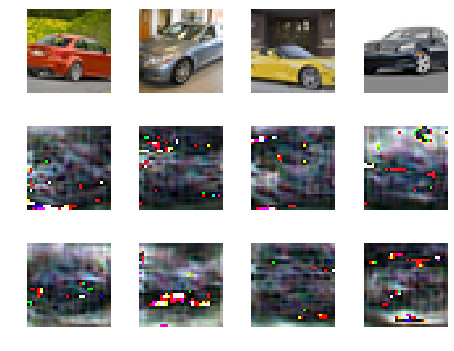

discriminator loss at step 600:	 0.9716759324073792 	-- adversarial loss at step 600:	 1.4203225
discriminator loss at step 700:	 1.0584230422973633 	-- adversarial loss at step 700:	 1.0898557
discriminator loss at step 800:	 1.2276314496994019 	-- adversarial loss at step 800:	 1.3334316
discriminator loss at step 900:	 1.0354743003845215 	-- adversarial loss at step 900:	 1.1893466
discriminator loss at step 1000:	 1.375168800354004 	-- adversarial loss at step 1000:	 1.4272015


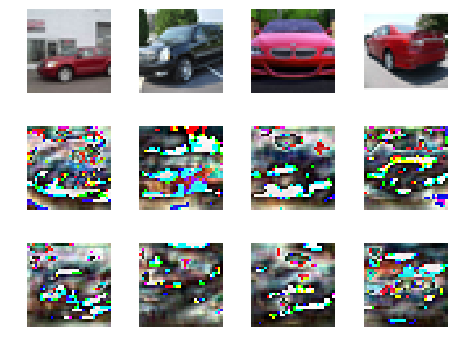

discriminator loss at step 1100:	 1.0522329807281494 	-- adversarial loss at step 1100:	 1.2598207
discriminator loss at step 1200:	 1.0653756856918335 	-- adversarial loss at step 1200:	 1.4948468
discriminator loss at step 1300:	 0.9130394458770752 	-- adversarial loss at step 1300:	 1.339983
discriminator loss at step 1400:	 1.0461541414260864 	-- adversarial loss at step 1400:	 1.6185735
discriminator loss at step 1500:	 0.9771190881729126 	-- adversarial loss at step 1500:	 1.2990052


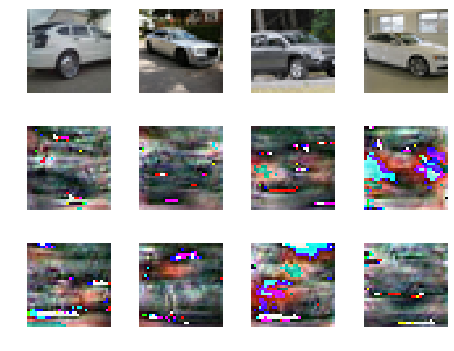

discriminator loss at step 1600:	 1.1723346710205078 	-- adversarial loss at step 1600:	 1.5002289
discriminator loss at step 1700:	 1.0717666149139404 	-- adversarial loss at step 1700:	 1.2772496
discriminator loss at step 1800:	 0.9778125286102295 	-- adversarial loss at step 1800:	 1.495307
discriminator loss at step 1900:	 0.8708406686782837 	-- adversarial loss at step 1900:	 1.4028182
discriminator loss at step 2000:	 1.0022180080413818 	-- adversarial loss at step 2000:	 1.5990092


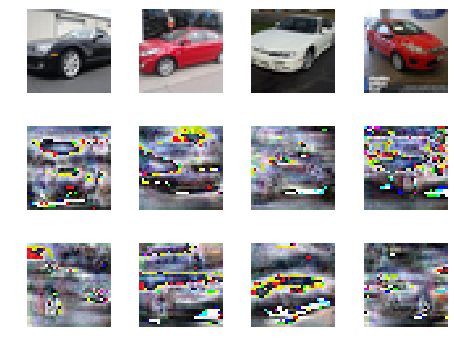

discriminator loss at step 2100:	 1.0443525314331055 	-- adversarial loss at step 2100:	 1.3620563
discriminator loss at step 2200:	 0.9288479685783386 	-- adversarial loss at step 2200:	 1.6453059
discriminator loss at step 2300:	 0.9367777705192566 	-- adversarial loss at step 2300:	 1.4985931
discriminator loss at step 2400:	 1.0320096015930176 	-- adversarial loss at step 2400:	 1.8061724
discriminator loss at step 2500:	 1.0095055103302002 	-- adversarial loss at step 2500:	 1.5440433


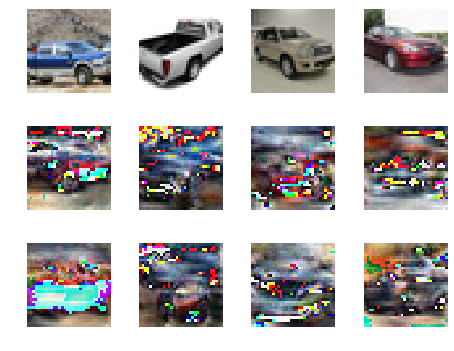

discriminator loss at step 2600:	 0.9459875822067261 	-- adversarial loss at step 2600:	 1.4644976
discriminator loss at step 2700:	 1.0556305646896362 	-- adversarial loss at step 2700:	 1.5554659
discriminator loss at step 2800:	 1.167822003364563 	-- adversarial loss at step 2800:	 1.398957
discriminator loss at step 2900:	 0.9823188781738281 	-- adversarial loss at step 2900:	 1.5366278
discriminator loss at step 3000:	 0.9725182056427002 	-- adversarial loss at step 3000:	 1.2875159


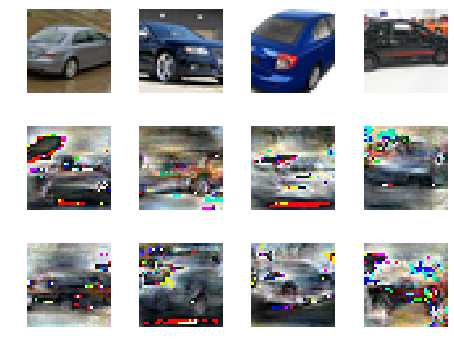

discriminator loss at step 3100:	 1.0434316396713257 	-- adversarial loss at step 3100:	 1.2285628
discriminator loss at step 3200:	 1.0162413120269775 	-- adversarial loss at step 3200:	 1.4812058
discriminator loss at step 3300:	 0.8655924201011658 	-- adversarial loss at step 3300:	 1.206618
discriminator loss at step 3400:	 0.9883573055267334 	-- adversarial loss at step 3400:	 1.359405
discriminator loss at step 3500:	 0.9283040165901184 	-- adversarial loss at step 3500:	 1.474158


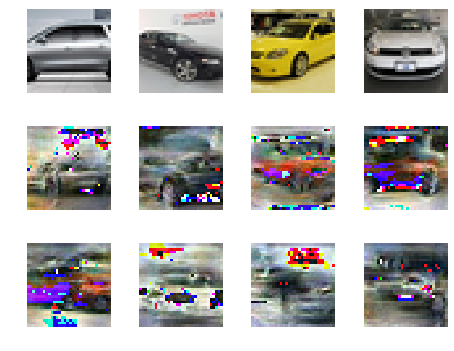

discriminator loss at step 3600:	 0.8991555571556091 	-- adversarial loss at step 3600:	 1.7458508
discriminator loss at step 3700:	 1.0768709182739258 	-- adversarial loss at step 3700:	 1.3264874
discriminator loss at step 3800:	 1.0320448875427246 	-- adversarial loss at step 3800:	 1.4827969
discriminator loss at step 3900:	 1.090044379234314 	-- adversarial loss at step 3900:	 1.4977131
discriminator loss at step 4000:	 0.9689921140670776 	-- adversarial loss at step 4000:	 1.3966627


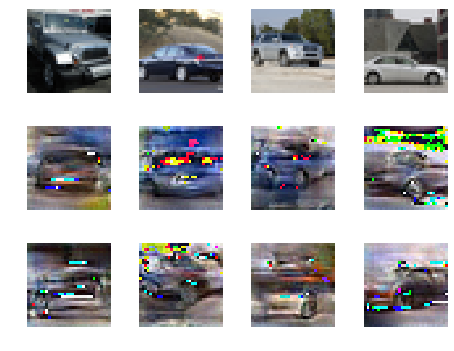

discriminator loss at step 4100:	 0.989510715007782 	-- adversarial loss at step 4100:	 1.2152917
discriminator loss at step 4200:	 0.9184457063674927 	-- adversarial loss at step 4200:	 1.4988365
discriminator loss at step 4300:	 1.1187107563018799 	-- adversarial loss at step 4300:	 1.459857
discriminator loss at step 4400:	 1.2050938606262207 	-- adversarial loss at step 4400:	 1.3590271
discriminator loss at step 4500:	 1.0234968662261963 	-- adversarial loss at step 4500:	 1.3274982


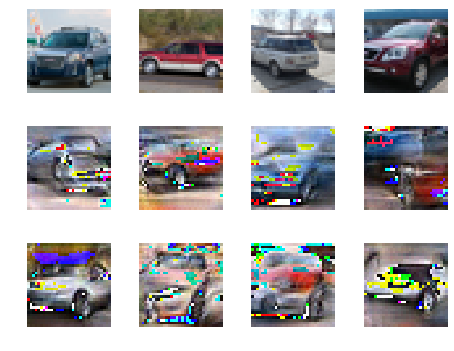

discriminator loss at step 4600:	 1.0702686309814453 	-- adversarial loss at step 4600:	 1.3327068
discriminator loss at step 4700:	 0.998508870601654 	-- adversarial loss at step 4700:	 1.1804938
discriminator loss at step 4800:	 1.089280366897583 	-- adversarial loss at step 4800:	 1.2270049
discriminator loss at step 4900:	 1.153024673461914 	-- adversarial loss at step 4900:	 1.2784936


In [ ]:
#Should be a higher number. For learning purposes I have setted this value with a low value.
iterations = 5000

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = np.zeros((batch_size, width, height, channels), dtype=np.float64)

    cont = 0
    for k in range(start, stop):
        real_images[cont] = generate_real(train_df, k, (width, height));
        cont += 1

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.ones((batch_size, 1))

    # Add random noise to the labels - important trick!
    labels_real += 0.05 * np.random.random(labels_real.shape)
    labels_fake += 0.05 * np.random.random(labels_fake.shape)

    # Train the discriminator
    d_loss1 = discriminator.train_on_batch(real_images, labels_real)
    d_loss2 = discriminator.train_on_batch(generated_images, -labels_fake)
    d_loss = 0.5 * (d_loss1 + d_loss2)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.ones((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(train_df) - batch_size:
        start = 0

    if step % 100 == 0:
        print('discriminator loss at step %s:\t %s \t-- adversarial loss at step %s:\t %s' % (step, d_loss, step, a_loss))

    # Occasionally save / plot
    if step % 500 == 0:
        showimages = np.concatenate([real_images[:4], generated_images[:8]])
        plot_images(save2file=False, fake=True, samples=12, images=showimages, dpi=60)


Finally, we will show some generated images.

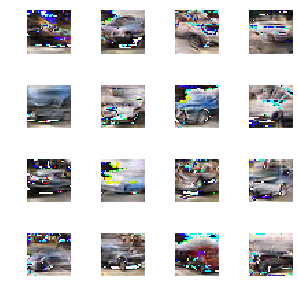

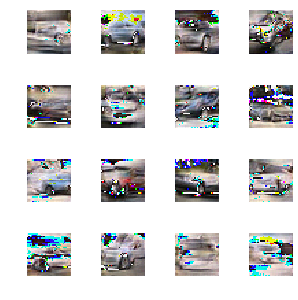

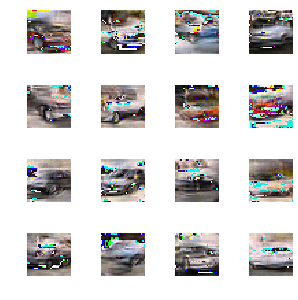

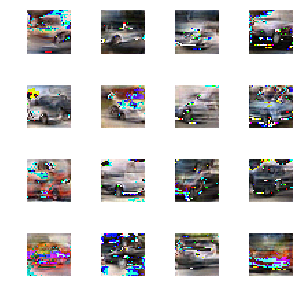

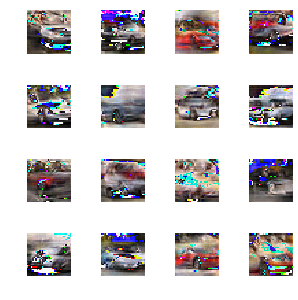

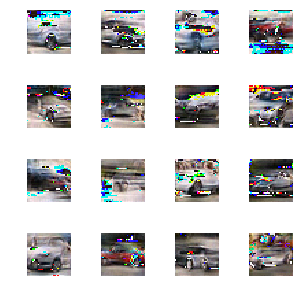

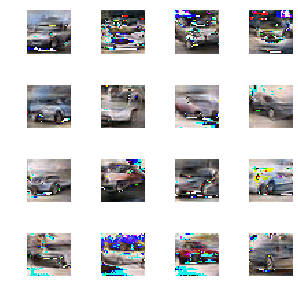

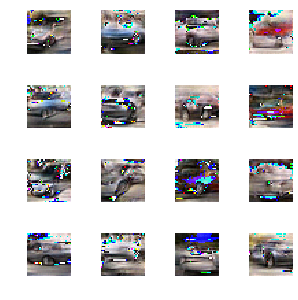

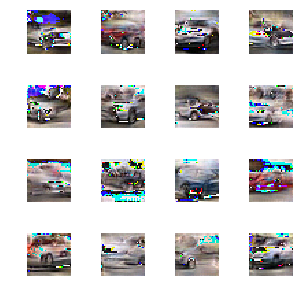

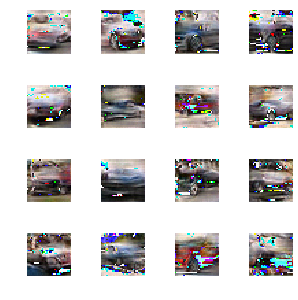

In [ ]:
for k in range(0, 10):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    plot_images(save2file=False, fake=True, samples=16, images=generated_images[:16], dpi=120)